File No longer In Use!!!

1. preprocessing. ipynb
2. transferLearning.ipynb
3. trainModel.ipynb

In [2]:
import pandas as pd
import numpy as np

Substitute for own data path

In [3]:
#df = pd.read_csv(r'C:\Users\eric7\OneDrive\Desktop\aps360Project\convolutional-neural-nuts\data\set.csv')
df = pd.read_csv("../data/set.csv")
print("successfully retrieved csv file")

successfully retrieved csv file


IN CSV files, formate as [path:genus]
Created a dictionary that has keys as genus, and items as image paths

In [4]:
grouped = df.groupby('Genus')['Path'].apply(list).to_dict()

mapping = {key: np.array(value) for key, value in grouped.items()}

Analysis of data
- help decide cnn approach
- all data in a numpy dictionary called mapping

In [5]:
print(f"number of classes: {len(mapping)}")

number of classes: 10


In [6]:
LessThan75 = 0
MoreThan75 = 0
totalCount = 0
for dict_keys in mapping.keys():
    totalCount += len(mapping[dict_keys])
    if len(mapping[dict_keys]) > 75:
        print(f"Class name: {dict_keys}, number of images: {len(mapping[dict_keys])}")
        MoreThan75 += 1
    else:
        LessThan75 += 1
print(f"More than 75: {MoreThan75}")
print(f"Less Than 75: {LessThan75}")
print(f"Total Images {totalCount}")

Class name: Cookeina tricholoma, number of images: 1703
Class name: Coprinellus disseminatus, number of images: 912
Class name: Cyathus sp, number of images: 872
Class name: Filoboletus gracilis, number of images: 783
Class name: Hygrocybe trinitensis complexo, number of images: 919
Class name: Marasmius amazonicus, number of images: 2856
Class name: Oudemansiella cubensis, number of images: 984
Class name: Phallus indusiatus complex, number of images: 1328
Class name: Pycnoporus sanguineus, number of images: 951
Class name: Schizophyllum commune, number of images: 1008
More than 75: 10
Less Than 75: 0
Total Images 12316


In [7]:
#variable to track number of clases
#n = int(len(mapping) * 3/4)
n=10
print(n)

10


CNN model with transfer learning

In [8]:
#imports
#need to pip install torch here
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image

In [10]:
#modify structure for dropout implementation

class preLearnedFungaV1(nn.Module):
    def __init__(self):
        super(preLearnedFungaV1, self).__init__()
        self.name = "fungaV1"
        #added anther convolution channel before fc layers
        self.conv1 = nn.Conv2d(256, 128, 3, 1, 1)
        self.fc1 = nn.Linear(128*6*6, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, n)

        #dropout implementation
        self.dropout1 = nn.Dropout(0.1)
        self.dropout2 = nn.Dropout(0.1)
        self.dropout3 = nn.Dropout(0.1)
        self.dropout4 = nn.Dropout(0.1)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.dropout1(x)
        x = x.view(x.size(0), -1)

        #FC layers
        x = self.dropout2(x)
        x = F.relu(self.fc1(x))
        
        x = self.dropout3(x)
        x = F.relu(self.fc2(x))

        x = self.dropout4(x)
        x = self.fc3(x)
        x = x.squeeze(1)  
        return x

Create training, validation and testing
- apply the transfer learning here

In [11]:
#need to install torchvision
from torch.utils.data import TensorDataset
from torchvision import transforms
#adjust to 224 dimension (input to alexnet)
transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((224,224))])

In [12]:
#use alexnet
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

c:\Users\eric7\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\eric7\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
#running this takes a long time, only do it after set.csv is fixed
dict = {}
print(f"Total number of classes {n}")
print("Start Transfer Learning Section: AlexNet feature extract for each class")
iterCount = 1

for key, images in mapping.items():
    if iterCount > n:
        break
    print(f"Class {iterCount} out of {n}")
    dict[key] = []
    for img in images:
        newImg = Image.open(img)
        newImg = transform(newImg)
        feat = alexnet.features(newImg)
        dict[key].append(feat)
    iterCount += 1


Total number of classes 10
Start Transfer Learning Section: AlexNet feature extract for each class
Class 1 out of 10
Class 2 out of 10
Class 3 out of 10
Class 4 out of 10
Class 5 out of 10
Class 6 out of 10
Class 7 out of 10
Class 8 out of 10
Class 9 out of 10
Class 10 out of 10


In [14]:
#change from str key to numerical key
mappingStrToInt = {idx: value for idx, (key, value) in enumerate(dict.items())}
print(len(mappingStrToInt))

10


In [15]:
#numerical dictionary
numericalDict = {}
for idx, (key, value) in enumerate(dict.items()):
    numericalDict[idx] = value
print(len(numericalDict))

10


In [16]:
# Split data into training, validation, and testing sets
tData, tLabel = [], []
vData, vLabel = [], []
testingData, testingLabel = [], []

print("Running data dictionary")
numIter = 1
#0.75 training, 0.15 valdiation, 0.10 for testing
for key, values in numericalDict.items():
    if numIter > n:
        break
    numTrain = int(len(values) * 0.75)
    numVal = int(len(values) * 0.15)

    tLabel.extend([key] * numTrain)
    vLabel.extend([key] * numVal)
    testingLabel.extend([key] * (len(values) - numTrain - numVal))

    tData.extend(values[:numTrain])
    vData.extend(values[numTrain:numTrain + numVal])
    testingData.extend(values[numTrain + numVal:])

    numIter += 1
print("Complete Running Data Dictionary")
tTensor = torch.stack(tData)
vTensor = torch.stack(vData)
testingTensor = torch.stack(testingData)

tLabelTensor = torch.tensor(tLabel)
vLabelTensor = torch.tensor(vLabel)
testingLabelTensor = torch.tensor(testingLabel)

train_set = TensorDataset(tTensor, tLabelTensor)
validation_set = TensorDataset(vTensor, vLabelTensor)
test_set = TensorDataset(testingTensor, testingLabelTensor)

Running data dictionary
Complete Running Data Dictionary


In [17]:
print(f'tTensor shape: {tTensor.shape}')
print(f'vTensor shape: {vTensor.shape}')
print(f'testingTensor shape: {testingTensor.shape}')

tTensor shape: torch.Size([9236, 256, 6, 6])
vTensor shape: torch.Size([1842, 256, 6, 6])
testingTensor shape: torch.Size([1238, 256, 6, 6])


In [18]:
#testing if train, validation, and test sets work
print(len(train_set))
print(len(validation_set))
print(len(test_set))

9236
1842
1238


In [19]:
#save the pt files
torch.save(train_set, 'Atrain_set.pt')
torch.save(validation_set, 'Avalidation_set.pt')
torch.save(test_set, 'Atest_set.pt')

AT THIS POINT TENSOR IS SAVED!!!! 

TRAIN DIRECTLY USING V2LoadTrain.ipynb IN THE FUTURE

Data Loading

In [20]:
#customized data_loading function with variable batch size
import torch
def dataLoadFunction(BatchSize):
  train_load = torch.utils.data.DataLoader(train_set, batch_size = BatchSize, shuffle=True)
  validation_load = torch.utils.data.DataLoader(validation_set, batch_size = BatchSize)
  testing_load = torch.utils.data.DataLoader(test_set, batch_size = BatchSize)
  return train_load, validation_load, testing_load

Training code

In [49]:
def getValidationLoss(net, validation_loader, criterion):
  totalLoss = 0
  count = 0
  for data in validation_loader:
    inputs, labels = data
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    totalLoss += loss.item()
    count += inputs.size(0)
  totalLoss = totalLoss / count
  return totalLoss


#model name
def get_model_name(name, batch_size, lr, epoch):
    path = "modelStorage/model_{0}_bs{1}_lr{2}_epoch{3}".format(name, batch_size, lr, epoch)
    return path

#plotting helper function
import matplotlib.pyplot as plt
#plot image function
#modified from lab 2
def plot_training_curve(path):
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    n = len(train_loss)
    #plot model
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

In [45]:
import time

In [53]:
def train_net_TL(net, batchsize=24, learning_rate=0.007, num_epochs=12, weight_decay=0): #values here are defaults, should* be overwritten when called

  torch.manual_seed(1)

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.8, weight_decay = weight_decay)

  training_loader, validation_loader, _ = dataLoadFunction(batchsize)

  train_loss_graph = np.zeros(num_epochs)
  val_loss_graph = np.zeros(num_epochs)

  n = len(training_loader)
  startTime = time.time()
  for currepoch in range(num_epochs):
    #print("New epoch")
    trainLoss = 0
    net.train()
    for i, (inputs, labels) in enumerate(training_loader):
      optimizer.zero_grad()

      inputs = torch.tensor(inputs.detach().numpy()).to(inputs.device)
      outputs = net(inputs)

      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      trainLoss += loss.item()

    #print("Onto validation")
    net.eval()
    train_loss_graph[currepoch] = trainLoss/n
    val_loss_graph[currepoch] = getValidationLoss(net, validation_loader, criterion)
    if (currepoch % 5 == 0):
      print(f"Epoch: {currepoch} Training Loss: {train_loss_graph[currepoch]:.6f}, Validation Loss: {val_loss_graph[currepoch]:.6f}, Time: {time.time() - startTime:.2f} seconds")
      model_path = get_model_name(net.name, batchsize, learning_rate, currepoch)
      torch.save(net.state_dict(), model_path)
      np.savetxt("{}_train_loss.csv".format(model_path), train_loss_graph)
      np.savetxt("{}_val_loss.csv".format(model_path), val_loss_graph)
  print("Total time: ", time.time()-startTime)

  path = "modelStorage/model_{0}_bs{1}_lr{2}_epoch{3}".format(net.name, batchsize, learning_rate, num_epochs)
  np.savetxt("{}_train_loss.csv".format(path), train_loss_graph)
  np.savetxt("{}_val_loss.csv".format(path), val_loss_graph)

Training here

In [47]:
#global variabls - so you don't have to modify them everywhere
BATCH_SIZE = 36
NUM_EPOCHS = 21
LEARNING_RATE = 0.007

#With Weight Decay
WEIGHTDECAY = 0.001

In [54]:
net3TL = preLearnedFungaV1()
train_net_TL(net3TL, batchsize=BATCH_SIZE, num_epochs=NUM_EPOCHS)

#with weight decay: train_net_TL(net3TL, batchsize=BATCH_SIZE, num_epochs=NUM_EPOCHS, weight_decay=WEIGHTDECAY)

Epoch: 0 Training Loss: 1.025558, Validation Loss: 0.014415, Time: 2.81 seconds
Epoch: 5 Training Loss: 0.036667, Validation Loss: 0.011926, Time: 33.18 seconds
Epoch: 10 Training Loss: 0.014488, Validation Loss: 0.013110, Time: 70.17 seconds
Epoch: 15 Training Loss: 0.003944, Validation Loss: 0.013497, Time: 103.75 seconds
Epoch: 20 Training Loss: 0.001806, Validation Loss: 0.014007, Time: 131.33 seconds
Total time:  131.36118340492249


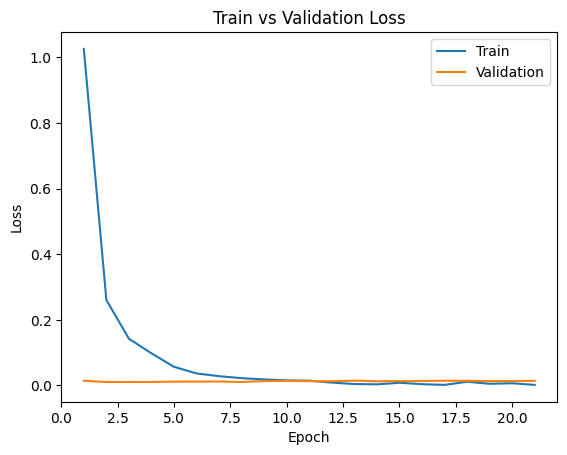

In [57]:
#plot curve here
plot_training_curve("modelStorage/model_{0}_bs{1}_lr{2}_epoch{3}".format("fungaV1", BATCH_SIZE, LEARNING_RATE, 20))

Test model

In [58]:
#test accuracy function
def getAccuracy(net, loader):
  correct, count = 0, 0
  net.eval()
  #no gradient modification
  with torch.no_grad():
    print("Total number of batches: ", len(loader))
    for currbatch, (i, corr) in enumerate(loader):
      count += corr.shape[0]
      print("CurrBatch: ", currbatch+1)

      correct += (torch.max(net(i), 1)[1] == corr).sum().item()

  return correct / count

In [60]:

bestNet = preLearnedFungaV1()
model_path = get_model_name("fungaV1", batch_size=BATCH_SIZE, lr=LEARNING_RATE, epoch=(15))
state = torch.load(model_path)
bestNet.load_state_dict(state)

_,_, testLoad = dataLoadFunction(24)

dataLoad = testLoad

accuracy = getAccuracy(bestNet, dataLoad)
print("Test Classification Accuracy: ", accuracy)

Total number of batches:  52
CurrBatch:  1
CurrBatch:  2
CurrBatch:  3
CurrBatch:  4
CurrBatch:  5
CurrBatch:  6
CurrBatch:  7
CurrBatch:  8
CurrBatch:  9
CurrBatch:  10
CurrBatch:  11
CurrBatch:  12
CurrBatch:  13
CurrBatch:  14
CurrBatch:  15
CurrBatch:  16
CurrBatch:  17
CurrBatch:  18
CurrBatch:  19
CurrBatch:  20
CurrBatch:  21
CurrBatch:  22
CurrBatch:  23
CurrBatch:  24
CurrBatch:  25
CurrBatch:  26
CurrBatch:  27
CurrBatch:  28
CurrBatch:  29
CurrBatch:  30
CurrBatch:  31
CurrBatch:  32
CurrBatch:  33
CurrBatch:  34
CurrBatch:  35
CurrBatch:  36
CurrBatch:  37
CurrBatch:  38
CurrBatch:  39
CurrBatch:  40
CurrBatch:  41
CurrBatch:  42
CurrBatch:  43
CurrBatch:  44
CurrBatch:  45
CurrBatch:  46
CurrBatch:  47
CurrBatch:  48
CurrBatch:  49
CurrBatch:  50
CurrBatch:  51
CurrBatch:  52
Test Classification Accuracy:  0.8683360258481422
